In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import shutil
import random
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from collections import defaultdict
import visualkeras
from PIL import ImageFont

In [44]:
#Clearing sessions to remove any previously accumulated weights
from tensorflow.keras import backend
backend.clear_session()

In [45]:
#Creating an instance for the dataset directory
input_dir = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Agricultural_Pets'

#Checking the created directories
os.listdir(input_dir)

['weevil',
 'catterpillar',
 'beetle',
 'earthworms',
 'wasp',
 'grasshopper',
 'moth',
 'ants',
 'bees',
 'earwig',
 'slug',
 'snail']

In [46]:
# Define the classes (folder names)
classes = ['weevil', 'catterpillar', 'beetle', 'earthworms', 'wasp',
           'grasshopper', 'moth', 'ants', 'bees', 'earwig', 'slug', 'snail']

# Initialize empty lists to store data
images = []
labels = []

# Define the expected file extensions
expected_extensions = [".jpg", ".jpeg", ".png"]  # Add more extensions as needed

# Loop through each class
for class_name in classes:
    class_dir = os.path.join(input_dir, class_name)

    # Loop through each image in the class folder
    for image_file in os.listdir(class_dir):
        file_name, file_extension = os.path.splitext(image_file)

        # Check if the file extension is in the list of expected extensions
        if file_extension.lower() in expected_extensions:
            image_path = os.path.join(class_dir, image_file)

            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Adjust the size as needed

            # Append the image data and label (convert label to string)
            images.append(image)
            labels.append(class_name)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels).reshape(-1, 1)  # Reshape labels to (4000, 1)

# Create a Pandas DataFrame for labels
pest_df = pd.DataFrame(labels, columns=["Label"])

# Save the Pandas DataFrame to a CSV file
pest_csv = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/data_labels.csv'
pest_df.to_csv(pest_csv, index=False)

# Save the NumPy arrays to the specified directory
Images = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/images.npy'
Labels = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/labels.npy'
np.save(Images, images)
np.save(Labels, labels)

print(f"Images saved to {Images}")
print(f"Labels and CSV saved to {pest_csv}")

Images saved to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/images.npy
Labels and CSV saved to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/data_labels.csv


In [47]:
#Loading the image and label files of the dataset

pest_images = np.load('/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/images.npy')

pest_labels = pd.read_csv('/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/data_labels.csv')

In [48]:
#Checking the shape of the image file
pest_images.shape

(5504, 128, 128, 3)

In [49]:
#Checking the shape of the label file
pest_labels.shape

(5504, 1)

In [50]:
#Checking 5 random rows in the labels file
pest_labels.sample(10)

Label
3114    moth
1199  beetle
5257   snail
4550  earwig
5236   snail
3217    ants
230   weevil
33    weevil
5316   snail
4056    bees

In [51]:
#Checking the unique labels
np.unique(pest_labels)

array(['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig',
       'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil'],
      dtype=object)

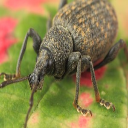

In [52]:
#Using openCV to show some random images
cv2_imshow(pest_images[10])

In [53]:
#Converting the images from BGR to RGB
for image in range(len(pest_images)):
  pest_images[image] = cv2.cvtColor(pest_images[image], cv2.COLOR_BGR2RGB)

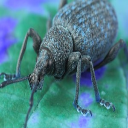

In [54]:
cv2_imshow(pest_images[10])

# **Explorative Data Analysis**

**There is a need to carry out some further data exploration to help gain further insight into the data**

In [55]:
#checking the unique number of pests in the dataset
pest_labels['Label'].nunique()

12

- Thus confirms that there are 12 different pests classes in the dataset

In [56]:
#Checking the number of each pest class
pest_labels['Label'].value_counts()

snail           510
bees            500
ants            499
wasp            498
moth            497
weevil          485
grasshopper     485
earwig          466
catterpillar    434
beetle          416
slug            391
earthworms      323
Name: Label, dtype: int64

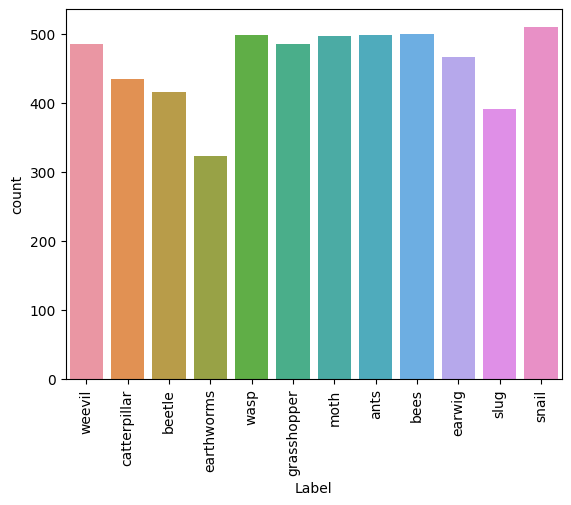

In [57]:
#Visualizing the classes in the dataset to help inspect for data imbalance
sns.countplot(x = 'Label', data = pest_labels, )
plt.xticks(rotation = 90);

- From the value counts and the bar plot above, it can be said that the classes are relatively balanced

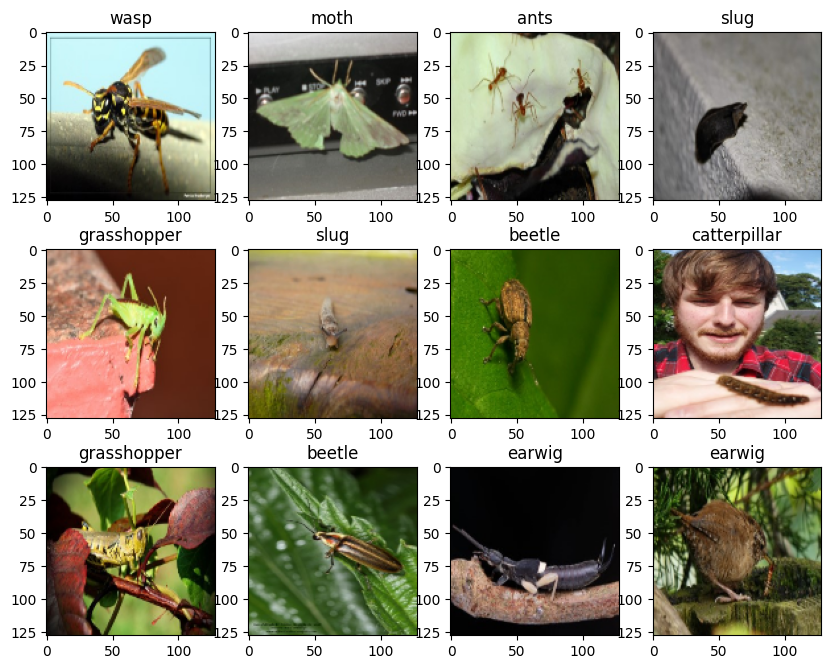

In [58]:
#Visualizing a random sample of 10 images and their their labels

def plot_images(pest_images, pest_labels):
  num_class = 12
  categories = np.unique(pest_labels)
  keys = dict(pest_labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize = (10, 8))
  for i in range(cols):
    for j in range(rows):
      random_index = np.random.randint(0, len(pest_labels))
      ax = fig.add_subplot(rows, cols, i * rows + j + 1)
      ax.imshow(pest_images[random_index, :])
      ax.set_title(keys[random_index])
  plt.show()

plot_images(pest_images, pest_labels)

# **Data Preprocessing**

## **Splitting the dataset**

- The dataset would be split into the training, validation and testing splits using train_test_split.
- Due to the size of the dataset, only 10% each would be allocated to testing and validation, leaving 80% for the training of the model

In [59]:
#Splitting the images into the training, validation and testing splits
x_temp, x_test, y_temp, y_test = train_test_split(np.array(pest_images), pest_labels, test_size = 0.1, random_state = 42, stratify = pest_labels)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size = 0.1, random_state = 42, stratify = y_temp)

In [60]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(4457, 128, 128, 3) (4457, 1)
(496, 128, 128, 3) (496, 1)
(551, 128, 128, 3) (551, 1)


## One Hot Encoding the labels

In [61]:
#Converting the pest names to one hot vectors using labelBinarizer

from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

## **Data Normalization**

- To normalize the images, the images would be divided by 255, which is the maximum pixel value images can have, therefore puting the images all on a scale of values between 0 and 1

In [62]:
#Normalizing the images

x_train_normalized = x_train.astype('float32')/255.0
x_val_normalized = x_val.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

## **Model Building; Convoluted Neural Network(CNN)**

In [63]:
#Clearing sessions to remove any previously accumulated weights
from tensorflow.keras import backend
backend.clear_session()

In [64]:
#Fixing the random state for number generators to ensure reproducibility

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [65]:
#Initializing a sequential model

model = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer
model.add(Conv2D(64, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))



#Building the second convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

#Building the third convolutional block consisting of a convolutional layer having 256 filters, a max pooling layer
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

#Building the fourth convolutional block consisting of a convolutional layer having 512 filters, a max pooling layer
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.5
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

#Adding the output layer with 12 neurons and an activation function of softmax
model.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 256)      0

In [66]:
#Defining early stopping and model checkpoint
model_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt = ModelCheckpoint(model_filename, verbose = 2, save_best_only = True)

In [67]:
#Fitting the model on the training data
history = model.fit(x_train_normalized, y_train_encoded,
                    validation_data = (x_val_normalized, y_val_encoded),
                    batch_size = 32, epochs = 50, verbose = 2, callbacks = [es, chkpt])

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.48014, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests.hdf5
140/140 - 9s - loss: 2.4832 - accuracy: 0.9166 - precision: 0.1429 - recall: 2.2437e-04 - auc: 0.5308 - val_loss: 2.4801 - val_accuracy: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5277 - 9s/epoch - 67ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.48014 to 2.39745, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests.hdf5
140/140 - 7s - loss: 2.4391 - accuracy: 0.9169 - precision: 0.5735 - recall: 0.0088 - auc: 0.5747 - val_loss: 2.3975 - val_accuracy: 0.9175 - val_precision: 0.8571 - val_recall: 0.0121 - val_auc: 0.6229 - 7s/epoch - 49ms/step
Epoch 3/50

Epoch 3: val_loss improved from 2.39745 to 2.23081, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests.hdf5
140/140 - 6s - loss: 2.3069 - accuracy: 0.9183 - precision: 0.6760 - recall: 0.03

### **From the model training above, it can be seen that;**
- The model appeared to be generalizing well at the start, it however began overfitting after the 5th epoch
- The training loss progressively dropped from 2.4695 to 0.5916 at the 13th epoch, while the validation loss stopped improving after the 10th epoch at 1.5375 from an initial 2.4408.
- The training accuracy was 96.9% on the 11th epoch, while validation accuracy was 92.8%

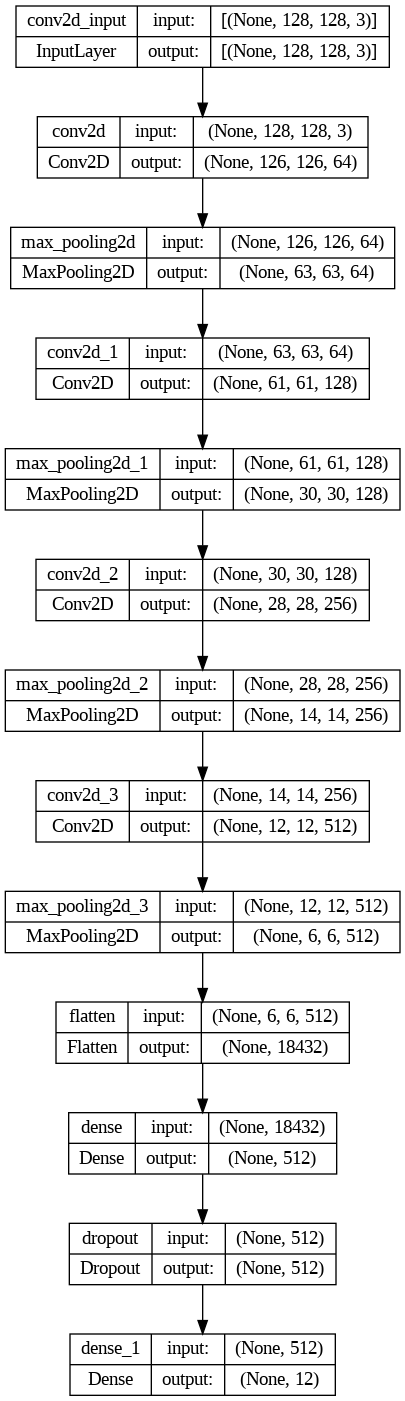

In [68]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

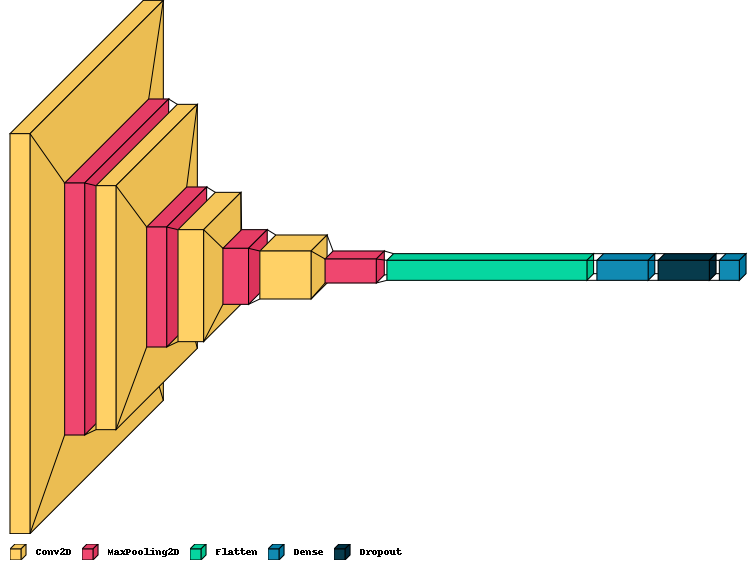

In [69]:
visualkeras.layered_view(model, legend=True, max_z = 200, max_xy = 400)

## **Model Evaluation**

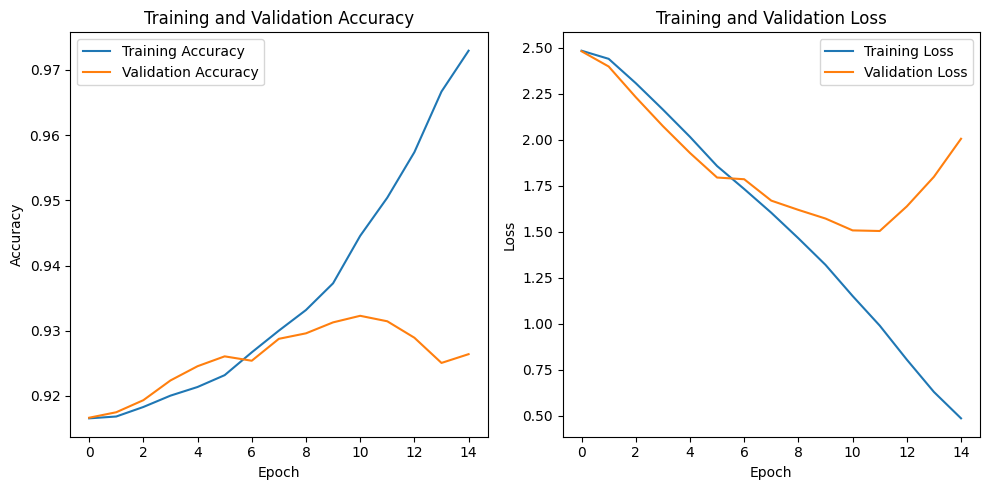

In [70]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- The above plot shows that the model overfitted after the 5th epoch

## **Evaluating the performance of the model on the test data**

In [71]:
accuracy = model.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 0s - loss: 2.2578 - accuracy: 0.9270 - precision: 0.5810 - recall: 0.4428 - auc: 0.8509 - 460ms/epoch - 26ms/step


- The model can still be seen to be overfitting on the test data as well

## **Making prediction using the test data**

In [72]:
#Making pest prediction on the test data
y_pred = model.predict(x_test_normalized)

18/18 [==============================] - 0s 16ms/step


## **Plotting comfusion matrix**
- The confusion matrix is a TensorFlow module that can be used to evaluate the performance of classification models
- The confusion matrix however expects inputs to be cartegorical. The y_test_encoded would therefore be required to be converted to categorical values
- The argmax() function would be used to retrieve the maximum value for each category, which is used to get the classes of the y_test_encoded and the y_pred(which is in probabilities)

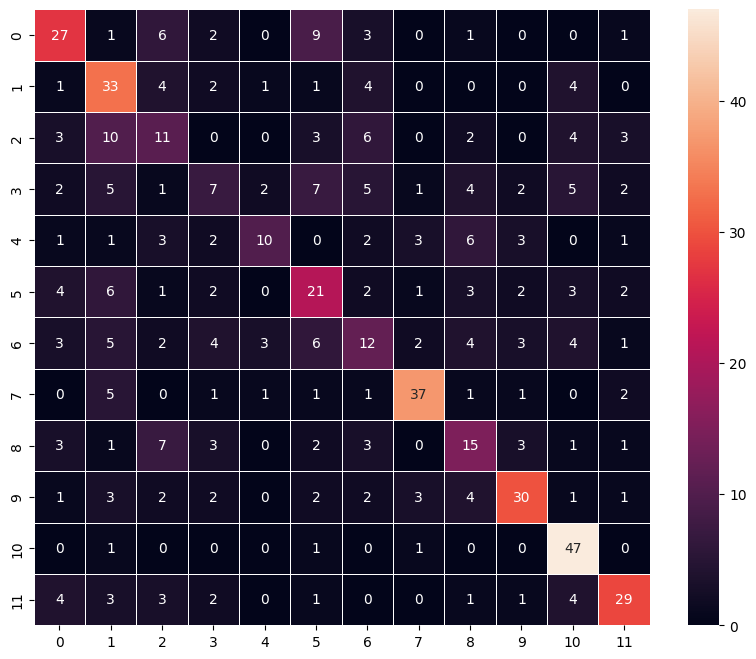

In [73]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- The model can be seen to be doing well in predicting only classes 7, 9, 10 and 11, and only fairly well in predicting class 1.

## **Model Architecture2**

- Padding is being introduced intom the model architecture so that the dimension of the input image into the various layers is maintained
- BatchNormalizer is also being introduced to improve the stability of the model

In [74]:
#Clearing sessions to remove any previously accumulated weights
backend.clear_session()

#Fixing the random state for number generators to ensure reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [75]:
#Initializing a second model
model2 = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer, padding and a batch normalizer
model2.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (128, 128, 3),
                 activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Building the second convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer, padding and a batch normalizer
model2.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Building the third convolutional block consisting of a convolutional layer having 256 filters, a max pooling layer, padding  and a batch normalizer
model2.add(Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Building the fourth convolutional block consisting of a convolutional layer having 512 filters, a max pooling layer, padding and a batch normalizer
model2.add(Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model2.add(Flatten())

#Adding a fully connected dense layer with 512 neurons and a dropout of 0.5
model2.add(Dense(512, activation = 'relu'))
model2.add(Dropout(0.5))

#Adding the output layer with 12 neurons and an activation function of softmax
model2.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                        

In [76]:
#Defining early stopping and model checkpoint
model2_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests2.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt2 = ModelCheckpoint(model2_filename, verbose = 1, save_best_only = True)

In [77]:
#Fitting the model on the training data
history2 = model2.fit(x_train_normalized, y_train_encoded,
                    validation_data = (x_val_normalized, y_val_encoded),
                    batch_size = 32, epochs = 50, verbose = 1, callbacks = [es, chkpt2])

Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 7.5764 - accuracy: 0.8940 - precision: 0.1522 - recall: 0.0595 - auc: 0.5433
Epoch 1: val_loss improved from inf to 25.00712, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests2.hdf5
140/140 [==============================] - 24s 153ms/step - loss: 7.5764 - accuracy: 0.8940 - precision: 0.1522 - recall: 0.0595 - auc: 0.5433 - val_loss: 25.0071 - val_accuracy: 0.8481 - val_precision: 0.0887 - val_recall: 0.0887 - val_auc: 0.5165
Epoch 2/50
139/140 [============================>.] - ETA: 0s - loss: 2.4914 - accuracy: 0.9162 - precision: 0.3065 - recall: 0.0043 - auc: 0.5376
Epoch 2: val_loss improved from 25.00712 to 15.91760, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests2.hdf5
140/140 [==============================] - 12s 83ms/step - loss: 2.4914 - accuracy: 0.9162 - precision: 0.3065 - recall: 0.0043 - auc: 0.5374 - val_loss: 15.9176 - val_accura

- The training loss ranged from 5.5252 at the first epoch to 2.4797 at the 11th epoch
- The validation loss was 24.2374 at the first epoch and least at 2.4456 at the 16th epoch
- The training accuracy of the model was 91.7%, while the validation accuracy was also 91.7%
- The model appears to be generally overfitting as the validation loss does not decrease proportionately with the training loss.

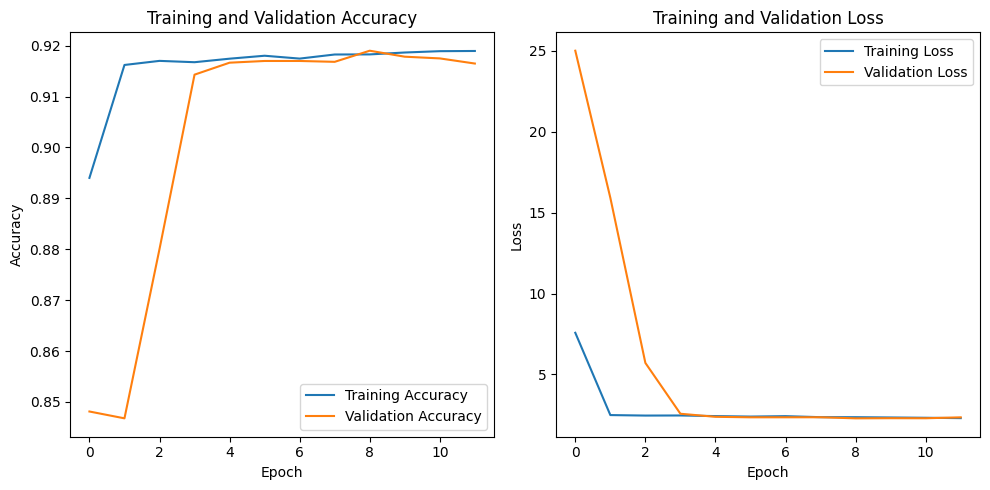

In [78]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- The above plot indeed shoes that the model generalizes well

## **Evaluating the performance of model2 on the test data**

In [79]:
accuracy2 = model2.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 1s - loss: 2.3347 - accuracy: 0.9170 - precision: 1.0000 - recall: 0.0036 - auc: 0.6574 - 549ms/epoch - 30ms/step


- The poor performance of the model can be seen to be maintained on the test data, as it has abysmally low precission and recall despite having high accuracy

## **Making prediction using the test data**

In [80]:
y_pred2 = model2.predict(x_test_normalized)

18/18 [==============================] - 0s 12ms/step


## **Plotting confusion matrix**

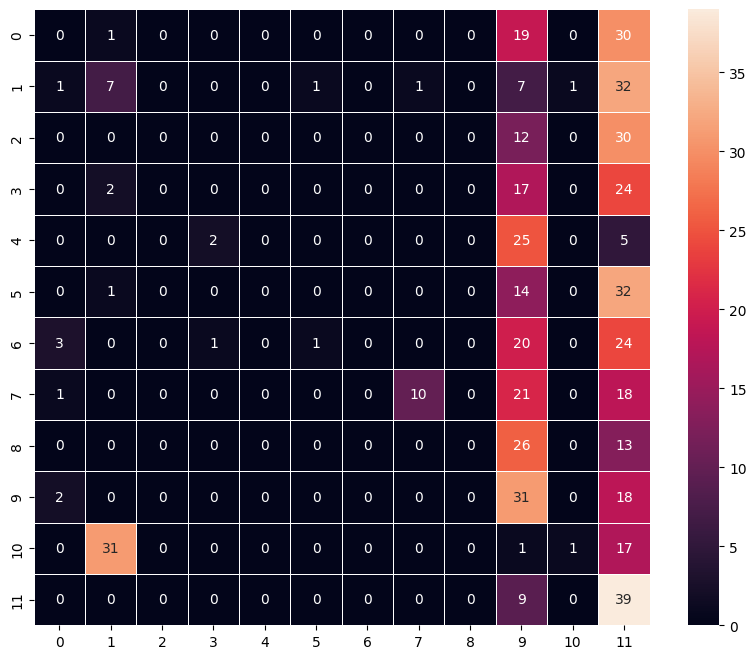

In [81]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred2_arg = np.argmax(y_pred2, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred2_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- From the above, the model can be seen to be performing really poorly as it is misclassifying the pest classes

## **Model Architecture3**

- To try and improve the performance of the model, data augmentation would be applied, and the learning rate would also be adjusted

**Data Augmentation**

To improve the performance of the model, the size of the data can be increased, using data augmentation. The data can be augmented by applying some changes on the provided image, and storing the changes as a new image. Example of possible changes are listed below;
  - Rotation
  - Height shift
  - Width shift
  - Horizontal flip
  - Vertical flip
  - Shear

**Learning Rate Tuning**

Learning rate would be adjusted from the default 0.001 to 0.0001


**These would be applied to the first architecture in an atempt to improve its performance**

In [82]:
train_datagen = ImageDataGenerator(rotation_range=180, fill_mode='nearest', horizontal_flip=True, vertical_flip=True, shear_range=0.2, zoom_range=0.2)

In [83]:
#Clearing sessions to remove any previously accumulated weights
backend.clear_session()

In [84]:
#Fixing the random state for number generators to ensure reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [85]:
#Initializing a sequential model

model3 = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer
model3.add(Conv2D(64, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))



#Building the second convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer
model3.add(Conv2D(128, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

#Building the third convolutional block consisting of a convolutional layer having 256 filters, a max pooling layer
model3.add(Conv2D(256, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

#Building the fourth convolutional block consisting of a convolutional layer having 512 filters, a max pooling layer
model3.add(Conv2D(512, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model3.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.5
model3.add(Dense(512, activation = 'relu'))
model3.add(Dropout(0.5))

#Adding the output layer with 12 neurons and an activation function of softmax
model3.add(Dense(12, activation = 'softmax'))


#Specifying the optimizer and tuning the learning rate
opt = Adam(learning_rate=0.0001)

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model3.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 256)      0

In [86]:
#Defining early stopping and model checkpoint
model3_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests3.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt3 = ModelCheckpoint(model3_filename, verbose = 2, save_best_only = True)

In [87]:
#Fitting the model on the training data
epochs = 50
batch_size = 64
history3 = model3.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                         batch_size = batch_size, seed = 42,
                                         shuffle = False), validation_data =
                                          (x_val_normalized, y_val_encoded),
                      epochs = epochs, verbose = 1, steps_per_epoch =
                      x_train_normalized.shape[0] // batch_size, callbacks =
                       [es, chkpt3])

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 2.4678 - accuracy: 0.9167 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5518
Epoch 1: val_loss improved from inf to 2.42852, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests3.hdf5
69/69 [==============================] - 33s 447ms/step - loss: 2.4678 - accuracy: 0.9167 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5518 - val_loss: 2.4285 - val_accuracy: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6006
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 2.3797 - accuracy: 0.9168 - precision: 0.6047 - recall: 0.0059 - auc: 0.6292
Epoch 2: val_loss improved from 2.42852 to 2.29380, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests3.hdf5
69/69 [==============================] - 25s 360ms/step - loss: 2.3797 - accuracy: 0.9168 - precision: 0.6047 - recall: 0.0059 - auc: 0.6292 - val_loss: 2.2938 

- The training loss ranged from 2.4634 at the first epoch to 1.4511 at the 11th epoch
- The validation loss was 2.4205 at the first epoch and least at 1.5122 at the 25th epoch
- The training accuracy of the model was 93.3%, while the validation accuracy was 93.1%
- The model appears to have greately improved on both the training and validation loss and appears to be set to make correct classification

## **Model3 evaluation**

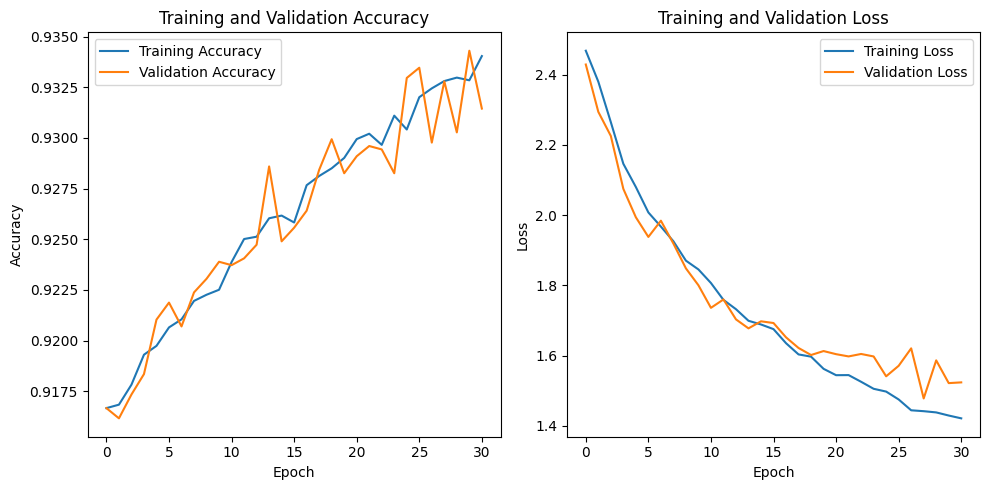

In [88]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- The model can from the above plot be confirmed to be generalizing well

## **Evaluating the performance of model3 on the test data**

In [89]:
accuracy3 = model3.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 0s - loss: 1.6273 - accuracy: 0.9301 - precision: 0.6705 - recall: 0.3176 - auc: 0.8694 - 361ms/epoch - 20ms/step


- The model can be seen to be maintaing it's perfromance on the test data

## **Making prediction using the test data**

In [90]:
y_pred3 = model3.predict(x_test_normalized)

18/18 [==============================] - 0s 16ms/step


## **Plotting confusion matrix**

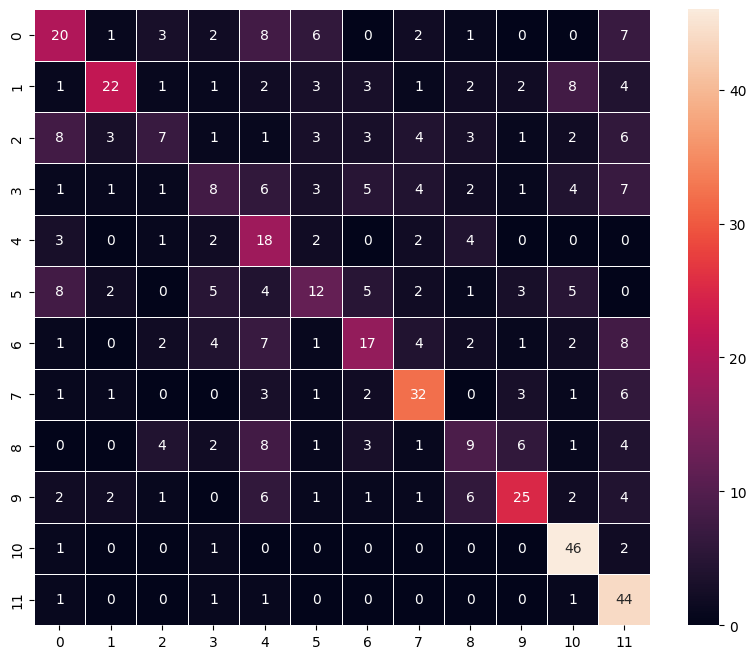

In [91]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred3_arg = np.argmax(y_pred3, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred3_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- A marked improvement can be observed in the prediction of the various classes. There is however still room for improvements.

## **Transfer Leasrning using VGG16**

- For this, a pretrained VGG16 model trained on ImageNet dataset would be used
- The convolutional and pooling layers of the pretrained VGG16 would be used.
- The fully connected layer of the pretrained architecture would however be replaced with that of the problem model for the classification task.

In [92]:
#Clearing sessions to remove any previously accumulated weights
backend.clear_session()

#Fixing the random state for number generators to ensure reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [93]:
#Importing the tranferlearning library, and loading the VGG16 model without its fully connected layes
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [94]:
#Freezing the VGG layers so that they don't get trained by the custom model
for layer in vgg_model.layers:
  layer.trainable = False

In [95]:
model4 = Sequential()

# Add the VGG16 layers
model4.add(vgg_model)

# Add the rest of your architecture
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(12, activation='softmax'))

# Compile the model
opt = Adam(learning_rate=0.0001)
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics)

# Generate the model summary
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
Total params: 18,915,660
Trainable params: 4,200,972
Non-trainable params: 14,714,688
_________________________________________________________________


In [96]:
#Defining early stopping and model checkpoint
model4_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests4.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt4 = ModelCheckpoint(model4_filename, verbose = 2, save_best_only = True)

In [97]:
#Fitting the pretrained model on the training data
epochs = 50
batch_size = 64
history_vgg16 = model4.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                         batch_size = batch_size, seed = 42,
                                         shuffle = False), validation_data =
                                          (x_val_normalized, y_val_encoded),
                      epochs = epochs, verbose = 1, steps_per_epoch =
                      x_train_normalized.shape[0] // batch_size, callbacks =
                       [es, chkpt4])

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 2.2123 - accuracy: 0.9188 - precision: 0.7350 - recall: 0.0392 - auc: 0.7112
Epoch 1: val_loss improved from inf to 1.76470, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests4.hdf5
69/69 [==============================] - 32s 416ms/step - loss: 2.2123 - accuracy: 0.9188 - precision: 0.7350 - recall: 0.0392 - auc: 0.7112 - val_loss: 1.7647 - val_accuracy: 0.9256 - val_precision: 0.8630 - val_recall: 0.1270 - val_auc: 0.8483
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 1.8023 - accuracy: 0.9257 - precision: 0.7905 - recall: 0.1477 - auc: 0.8307
Epoch 2: val_loss improved from 1.76470 to 1.54805, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests4.hdf5
69/69 [==============================] - 27s 385ms/step - loss: 1.8023 - accuracy: 0.9257 - precision: 0.7905 - recall: 0.1477 - auc: 0.8307 - val_loss: 1.5481 - val_accuracy: 0.9293 -

- The model architecture built on the pretrained VGG16 model is generalizing well, doing slightly better on the validation data than on the training data
- The validation loss progressively decreased, peaking at the 14th epoch, where it recorded a loss of 1.1439 form an initial 1.7549.
- The highest training accuracy was obtained at the 16th epoch where the model stopped to prevent overfitting. The training and validation accuracies both stood at 94%.

## **Model4 evaluation**

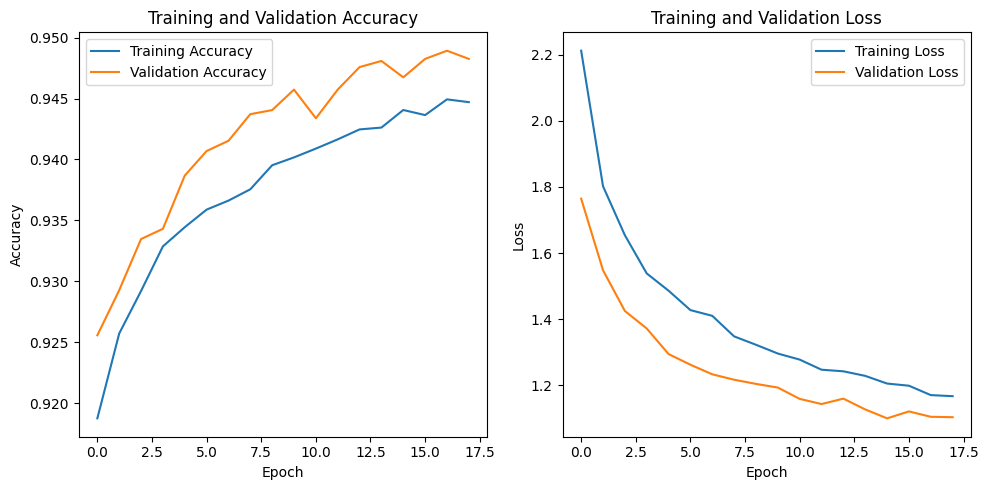

In [99]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- From the above plot, it can be seen that the model built with the pretrained vgg16 model is doing well both on the training and the validation datasets

## **Evaluating the performance of the pretrained model on the test data**

In [100]:
accuracy4 = model4.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 2s - loss: 1.1525 - accuracy: 0.9493 - precision: 0.8396 - recall: 0.4846 - auc: 0.9334 - 2s/epoch - 96ms/step


- The model performance is seen to be maintained on the training data

## **Making prediction using the test data**

In [101]:
y_pred4 = model4.predict(x_test_normalized)

18/18 [==============================] - 1s 51ms/step


## **Plotting confusion matrix**

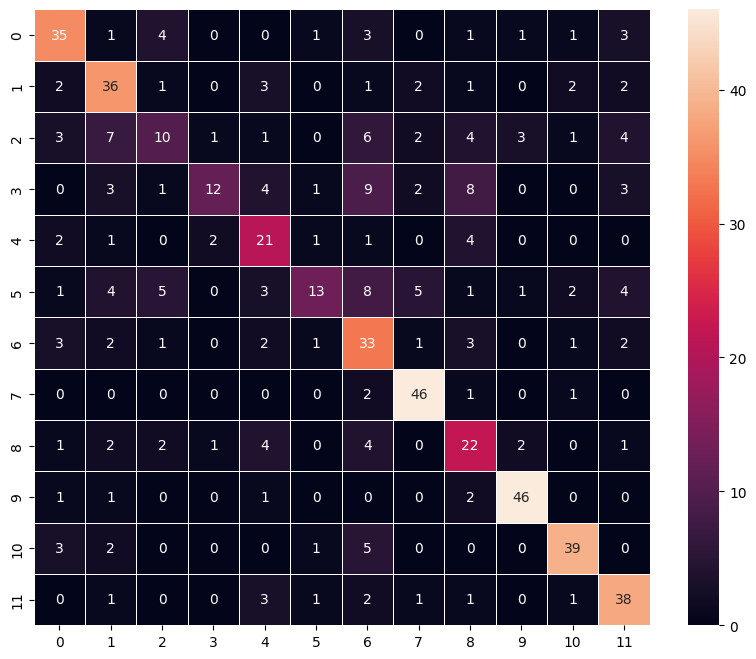

In [102]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred4_arg = np.argmax(y_pred4, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred4_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- From the concusion matrix above, the model can be seen to be doing a good job in classifyiong the pest classes

## **Transfer Leasrning using Efficient**

- For this, another pretrained model; EfficientNetB7 also trained on ImageNet dataset would be used
- The convolutional and pooling layers of the pretrained VGG16 would be used.
- The fully connected layer of the pretrained architecture would however be replaced with that of the problem model for the classification task.
- Data Augmentation is introduced to try and improve the performance of the model

In [103]:
#Importing necessary libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
import json

In [104]:
#Clearing sessions to remove any previously accumulated weights
backend.clear_session()

#Fixing the random state for number generators to ensure reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [105]:
# Load the pre-trained EfficientNetB0 model without the top classification layers
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Adding the classification layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(12, activation='softmax')(x)

# Create the final model for transfer learning
model5 = Model(inputs=base_model.input, outputs=output)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)

# Adding dropout layers for regularization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
output = Dense(12, activation='softmax')(x)

# ... (previous code)

# Compile the model with a learning rate scheduler and optimizer
def lr_schedule(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Compile the model
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics)

# Display model summary
model5.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

In [106]:
# Define callbacks
model5_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests5.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt5 = ModelCheckpoint(model5_filename, verbose = 2, save_best_only = True)

In [107]:
# Convert tensors to NumPy arrays
x_train_normalized_np = np.array(x_train_normalized)
y_train_encoded_np = np.array(y_train_encoded)
x_val_normalized_np = np.array(x_val_normalized)
y_val_encoded_np = np.array(y_val_encoded)

# Fitting the pretrained model on the training data
epochs = 50
batch_size = 64
# Fitting the pretrained model on the training data with callbacks and data augmentation
history_EffB0 = model5.fit(train_datagen.flow(x_train_normalized_np, y_train_encoded_np,
                                              batch_size=batch_size, seed=42, shuffle=True),
                           validation_data=(x_val_normalized_np, y_val_encoded_np),
                           epochs=epochs, verbose=1,
                           steps_per_epoch=x_train_normalized_np.shape[0] // batch_size,
                           callbacks=[es, chkpt5, lr_scheduler, tf.keras.callbacks.TerminateOnNaN()])


Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 2.0706 - accuracy: 0.9250 - precision: 0.8846 - recall: 0.1147 - auc: 0.7836
Epoch 1: val_loss improved from inf to 2.52447, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests5.hdf5
69/69 [==============================] - 50s 521ms/step - loss: 2.0706 - accuracy: 0.9250 - precision: 0.8846 - recall: 0.1147 - auc: 0.7836 - val_loss: 2.5245 - val_accuracy: 0.9167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4868 - lr: 1.0000e-04
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 1.2482 - accuracy: 0.9439 - precision: 0.8922 - recall: 0.3710 - auc: 0.9311
Epoch 2: val_loss improved from 2.52447 to 2.52415, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests5.hdf5
69/69 [==============================] - 29s 421ms/step - loss: 1.2482 - accuracy: 0.9439 - precision: 0.8922 - recall: 0.3710 - auc: 0.9311 - val_loss: 2.5241

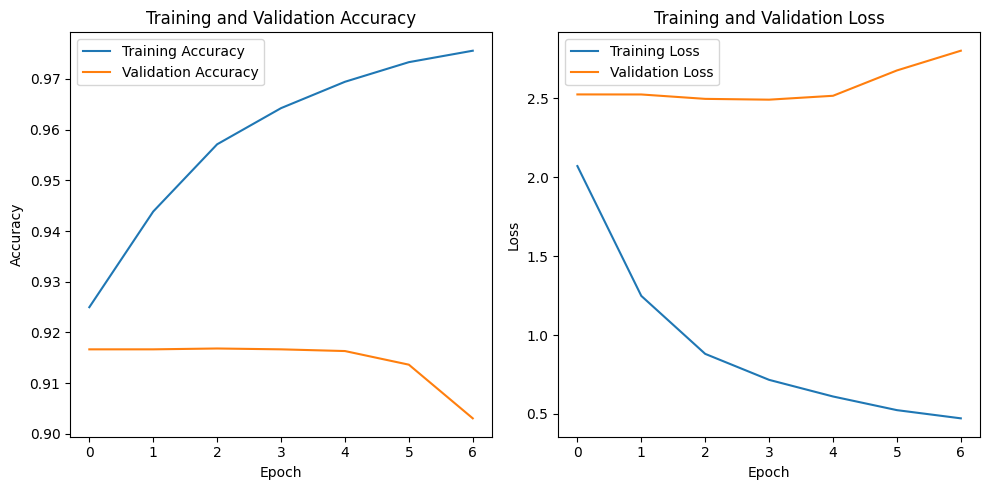

In [108]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_EffB0.history['accuracy'], label='Training Accuracy')
plt.plot(history_EffB0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_EffB0.history['loss'], label='Training Loss')
plt.plot(history_EffB0.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- From the above plot, the EfficientNet model can be seen to be clearly overfitting

## **Evaluating the performance of the EfficientNet pretrained model on the test data**

In [109]:
accuracy5 = model5.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 1s - loss: 2.6186 - accuracy: 0.9067 - precision: 0.3659 - recall: 0.1633 - auc: 0.7105 - 758ms/epoch - 42ms/step


- The model still performs poorly on the test data compared top the training data

## **Making prediction using the test data**

In [110]:
y_pred5 = model5.predict(x_test_normalized)

18/18 [==============================] - 2s 25ms/step


## **Plotting confusion matrix**

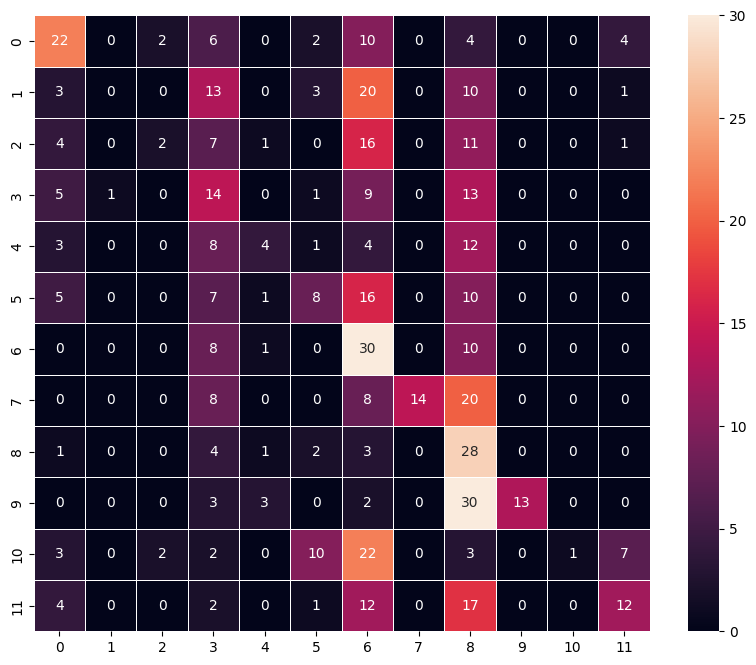

In [111]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred5_arg = np.argmax(y_pred5, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred5_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

## **Transfer Leasrning using MobileNetV2**

- For this, another pretrained model; MobileNetV2 also trained on ImageNet dataset would be used
- The convolutional and pooling layers of the pretrained MobileNet model would be used.
- The fully connected layer of the pretrained architecture would however be replaced with that of the problem model for the classification task.

In [112]:
#Clearing sessions to remove any previously accumulated weights
backend.clear_session()

#Fixing the random state for number generators to ensure reproducibility

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [113]:
#Importing the pretrained MobileNet model
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model without the top classification layers
Mnet_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))
Mnet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [114]:
#Freezing the MobileNet layers so that they don't get trained by the custom model
for layer in Mnet_model.layers:
  layer.trainable = False

In [115]:
#Initializing the sixth model
model6 = Sequential()

# Adding the convolutional part of the MobileNetV2 model above
model6.add(Mnet_model)

# Flattening the output of the MobileNetV2 model because it is from a convolutional layer
model6.add(Flatten())

# Adding a fully connected dense layer with 512 neurons and a dropout of 0.5
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5))

# Adding the output layer with 12 neurons and an activation function of softmax
model6.add(Dense(12, activation='softmax'))

# Specifying the optimizer
opt = Adam()

from tensorflow.keras.metrics import BinaryAccuracy

# Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

# Compiling the model
model6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=Metrics)

# Generating the model summary
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
Total params: 12,750,412
Trainable params: 10,492,428
Non-trainable params: 2,257,984
____________________________________

In [116]:
# Defining early stopping and model checkpoint
model6_filename = '/content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests6.hdf5'
es = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
chkpt6 = ModelCheckpoint(model6_filename, verbose=2, save_best_only=True)

In [117]:
# Data augmentation for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fitting the model on the training data
epochs = 50
batch_size = 64
history_Mnet = model6.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                                      batch_size=batch_size, seed=42,
                                                      shuffle=False),
                                    validation_data=(x_val_normalized, y_val_encoded),
                                    epochs=epochs, verbose=1,
                                    steps_per_epoch=x_train_normalized.shape[0] // batch_size,
                                    callbacks=[es, chkpt6])

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 3.0238 - accuracy: 0.9298 - precision: 0.6246 - recall: 0.3936 - auc: 0.8378
Epoch 1: val_loss improved from inf to 0.76591, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests6.hdf5
69/69 [==============================] - 32s 401ms/step - loss: 3.0238 - accuracy: 0.9298 - precision: 0.6246 - recall: 0.3936 - auc: 0.8378 - val_loss: 0.7659 - val_accuracy: 0.9654 - val_precision: 0.8940 - val_recall: 0.6633 - val_auc: 0.9709
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 1.1891 - accuracy: 0.9478 - precision: 0.7967 - recall: 0.5015 - auc: 0.9300
Epoch 2: val_loss improved from 0.76591 to 0.60826, saving model to /content/drive/MyDrive/Colab_Files/Applied_AI_Projects/Models/pests6.hdf5
69/69 [==============================] - 25s 359ms/step - loss: 1.1891 - accuracy: 0.9478 - precision: 0.7967 - recall: 0.5015 - auc: 0.9300 - val_loss: 0.6083 - val_accuracy: 0.9703 -

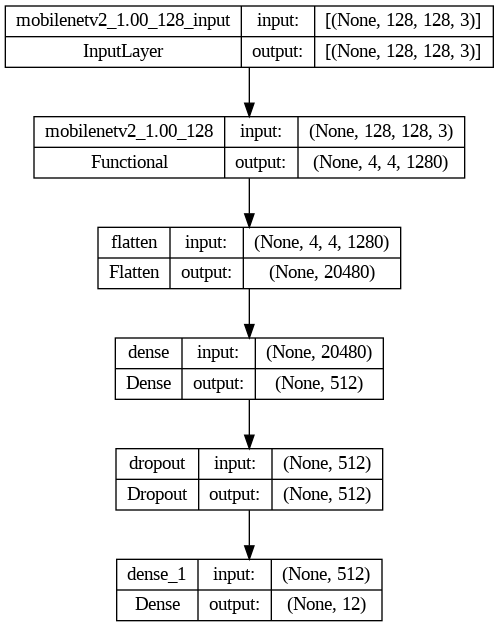

In [118]:
plot_model(model6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Pretrained model evaluation**

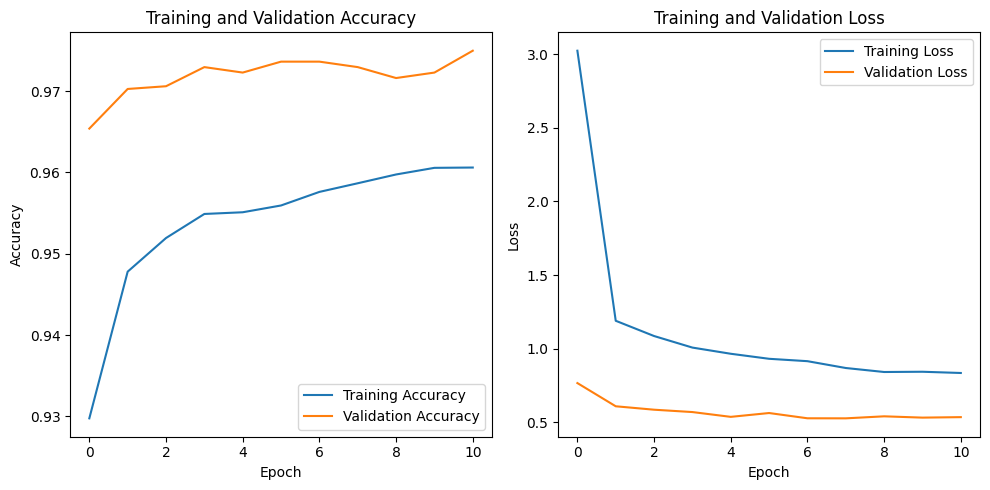

In [119]:
#Visualizing the performance of the model

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_Mnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_Mnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_Mnet.history['loss'], label='Training Loss')
plt.plot(history_Mnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Evaluating the performance of the MobileNetV2 pretrained model on the test data**

In [120]:
accuracy6 = model6.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

18/18 - 1s - loss: 0.6909 - accuracy: 0.9690 - precision: 0.8589 - recall: 0.7514 - auc: 0.9758 - 519ms/epoch - 29ms/step


## **Making prediction using the test data**

In [121]:
y_pred6 = model6.predict(x_test_normalized)

18/18 [==============================] - 1s 17ms/step


## **Plotting confusion matrix**

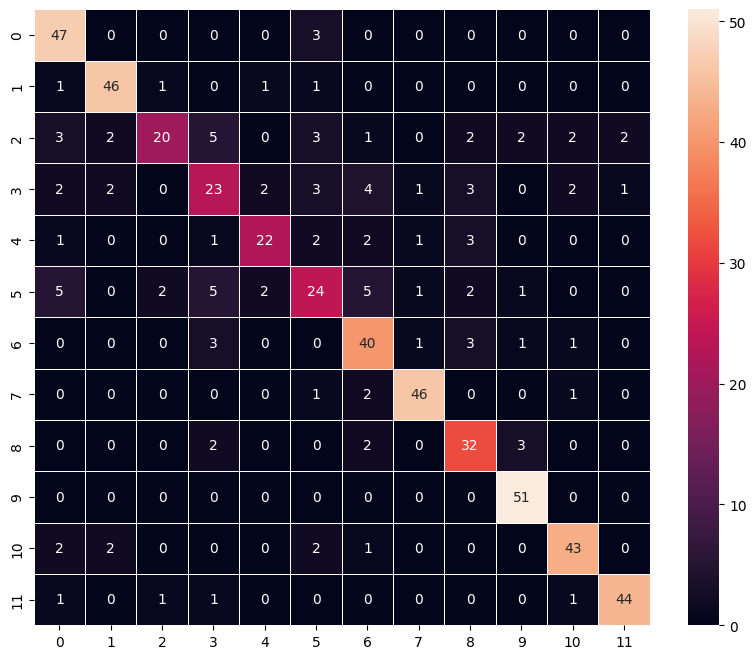

In [122]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred6_arg = np.argmax(y_pred6, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred6_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

1/1 [==============================] - 0s 40ms/step


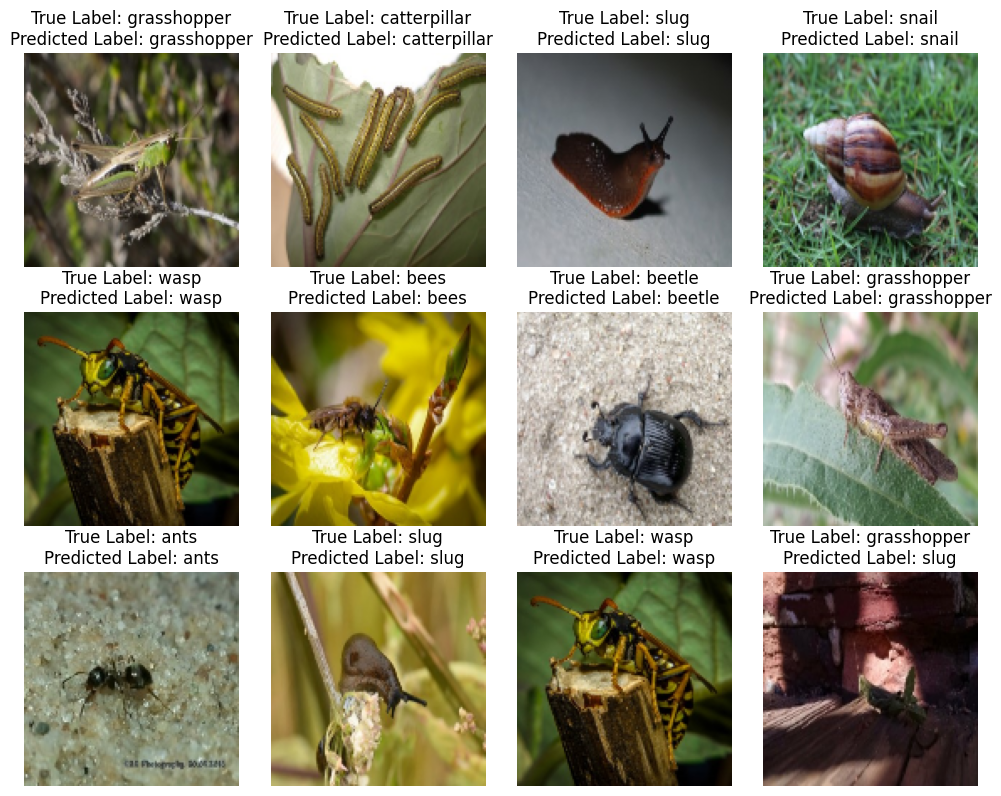

In [127]:
# Define a function for visualization
def visualize_image_predictions(model, images, labels, encoder):
    plt.figure(figsize=(10, 8))
    num_images = len(images)

    rows = 3
    cols = 4

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title("True Label: {}\nPredicted Label: {}".format(
            encoder.inverse_transform(labels[i:i+1])[0],
            encoder.inverse_transform(model.predict(images[i:i+1]))[0]
        ))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize images and predictions
images_to_visualize = x_test_normalized[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]
labels_to_visualize = y_test_encoded[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]

visualize_image_predictions(model6, np.array(images_to_visualize), labels_to_visualize, enc)

1/1 [==============================] - 0s 27ms/step


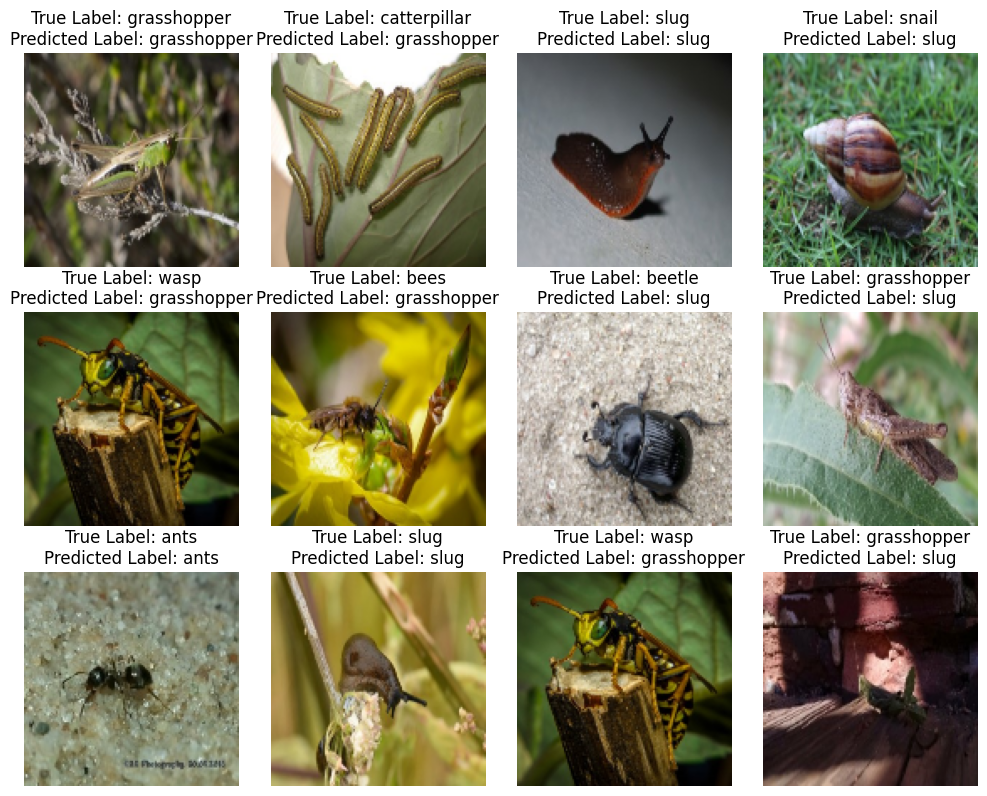

In [129]:
# Visualize images and predictions
images_to_visualize = x_test_normalized[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]
labels_to_visualize = y_test_encoded[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]

visualize_image_predictions(model5, np.array(images_to_visualize), labels_to_visualize, enc)

1/1 [==============================] - 0s 73ms/step


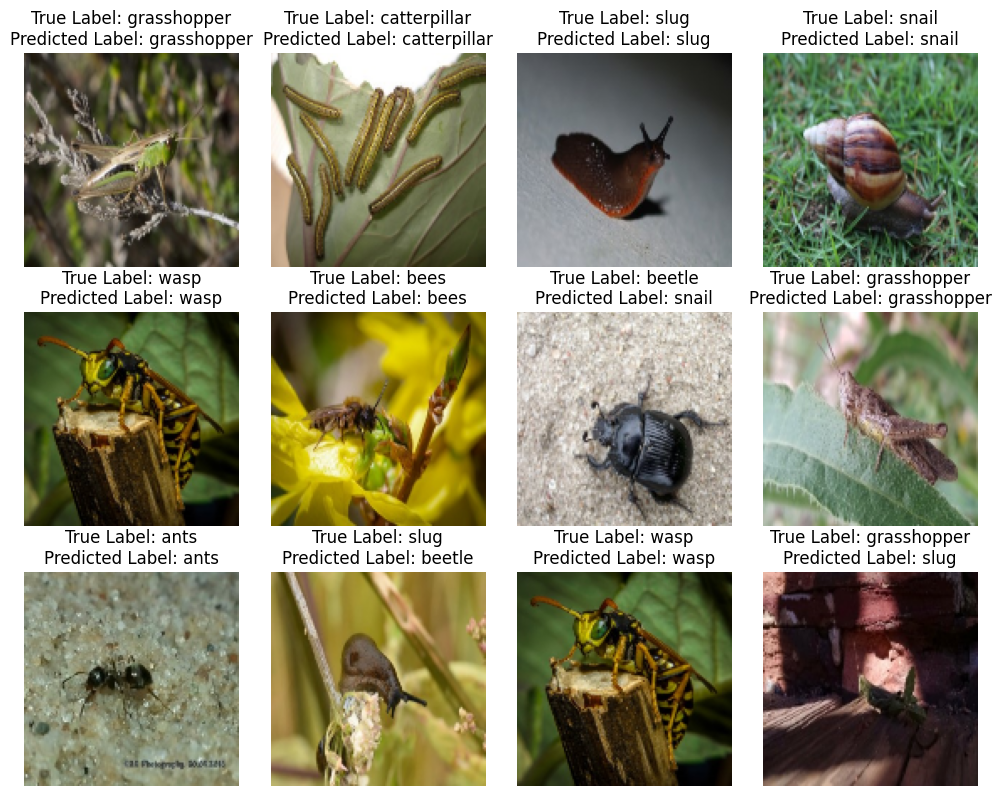

In [128]:
# Visualize images and predictions
images_to_visualize = x_test_normalized[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]
labels_to_visualize = y_test_encoded[[17, 120, 30, 4, 29, 44, 21, 23, 6, 0, 29, 7]]

visualize_image_predictions(model4, np.array(images_to_visualize), labels_to_visualize, enc)